# Detecão de Anomalias - Autoencoder

In [289]:
## qol
from tqdm import tqdm
import warnings
from silence_tensorflow import silence_tensorflow
warnings.filterwarnings('ignore')
silence_tensorflow()

## autoencoder
import tensorflow as tf
import keras.backend as K
from keras import models
from keras import layers
from keras import losses
from keras import callbacks

## utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
import plotly.express as px

## sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
import sklearn
sklearn.set_config(display='diagram')

## constantes
RANDOM_SEED = 42 ## existe outra?
VAL_SIZE = 0.2
EPOCHS = 100
BATCH_SIZE = 512
TRAINING_SIZE = 200000
VAL_SIZE = 0.2

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [292]:
## lendo os dados e dropando as colunas desnecessárias
df = (
    pd.read_csv('data/creditcard.csv')
    .drop(['Time','Amount'],axis=1)
)

## inspecionando o dataset
print(df.shape)
df.head()

(284807, 29)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


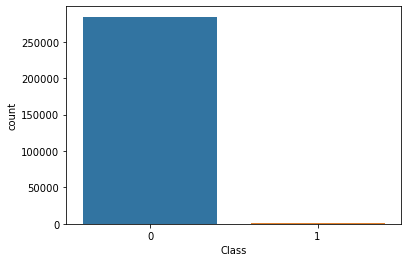

In [4]:
sns.countplot(df.Class)
plt.show()

In [5]:
df.Class.value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

In [6]:
## separando em datasets limpos e de fraude
clean = df[df.Class == 0]
fraud = df[df.Class == 1]

## undersmapling do dataset limpo
clean_undersampled = clean.sample(int(len(fraud)*15), random_state = RANDOM_SEED)

## juntando o dataset undersampled e de fraude
data_plot = pd.concat([clean_undersampled,fraud])

## coletando o nome das colunas de features
columns = list(data_plot.drop('Class',axis=1).columns)

## efeturando o tsne
features, target = data_plot[columns], data_plot.Class
features_embedding = TSNE(n_components=3,random_state=RANDOM_SEED,n_jobs=-1).fit_transform(features)

In [7]:
fig = px.scatter_3d(x=features_embedding[:,0],
                    y=features_embedding[:,1],
                    z=features_embedding[:,2],
                    color=target)

fig.update_traces(marker=dict(size=6,
                              opacity=0.6),
                  selector=dict(mode='markers'))

fig.show(renderer='iframe')

## Supervisionado - Novelty Detection

### Preparando o dataset

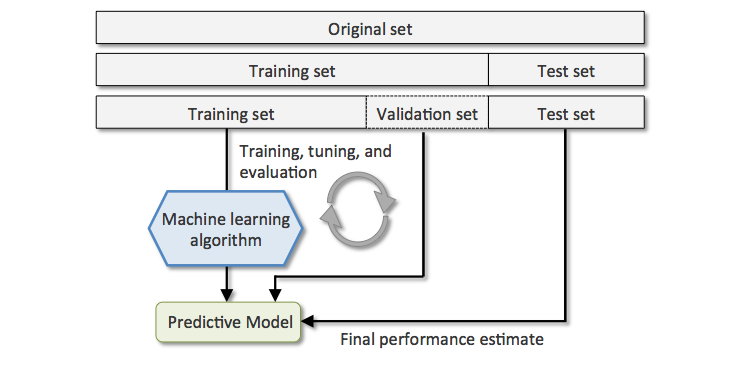

In [8]:
print(f"""Shape dos datasets:
    clean       (linhas, colunas) = {clean.shape}
    fraud       (linhas, colunas) = {fraud.shape}
    fraud/clean (em %)            = {round((fraud.shape[0]/clean.shape[0])*100,2)}%""")

Shape dos datasets:
    clean       (linhas, colunas) = (284315, 29)
    fraud       (linhas, colunas) = (492, 29)
    fraud/clean (em %)            = 0.17%


In [9]:
## dados sem fraude para treino

x_train = clean.iloc[:TRAINING_SIZE].sample(frac=1)
x_test  = clean.iloc[TRAINING_SIZE:].append(fraud).sample(frac=1)

x_test.Class.value_counts()

0    84315
1      492
Name: Class, dtype: int64

In [10]:
## criando dataset de treino e validação
x_train, x_val = train_test_split(x_train,
                                  test_size=VAL_SIZE,
                                  random_state=RANDOM_SEED)

## separando x e y de treino e validação
x_train, y_train = x_train.drop('Class',axis=1), x_train.Class
x_val  , y_val   = x_val.drop('Class',axis=1), x_val.Class

## separando x e y de teste
x_test, y_test = x_test.drop('Class',axis=1).values, x_test.Class.values

In [11]:
print(f"""Datasets:

df                                             : {df.shape}
│ 
├── treino -> dataset contendo somente dados de transações normais, utilizado para treinamento
│       │
│       ├── x_train                            : {x_train.shape}
│       │        └── x_train.non-fraud         : {y_train.value_counts()[0]}
│       │        └── x_train.fraud             : {0}
│       │        
│       └── x_val                              : {x_val.shape}
│               └── x_val.non-fraud            : {y_val.value_counts()[0]}
│               └── x_val.fraud                : {0}
│       
└── teste  -> dataset contendo uma mistura de transações normais e fraudulentas 
        │
        └── x_test                             : {x_test.shape}
                └── x_test.non-fraud           : {pd.Series(y_test).value_counts()[0]}
                └── x_test.fraud               : {pd.Series(y_test).value_counts()[1]}

""")

Datasets:

df                                             : (284807, 29)
│ 
├── treino -> dataset contendo somente dados de transações normais, utilizado para treinamento
│       │
│       ├── x_train                            : (160000, 28)
│       │        └── x_train.non-fraud         : 160000
│       │        └── x_train.fraud             : 0
│       │        
│       └── x_val                              : (40000, 28)
│               └── x_val.non-fraud            : 40000
│               └── x_val.fraud                : 0
│       
└── teste  -> dataset contendo uma mistura de transações normais e fraudulentas 
        │
        └── x_test                             : (84807, 28)
                └── x_test.non-fraud           : 84315
                └── x_test.fraud               : 492




In [12]:
## normalizando

pipe = make_pipeline(Normalizer(),MinMaxScaler())
pipe.fit(x_train)

Pipeline(steps=[('normalizer', Normalizer()), ('minmaxscaler', MinMaxScaler())])

In [13]:
x_train_scaled = pipe.transform(x_train)
x_val_scaled   = pipe.transform(x_val)

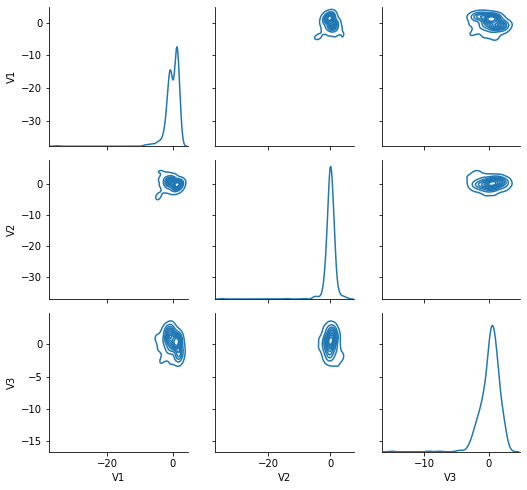

In [14]:
g = sns.PairGrid(x_train.iloc[:,:3].sample(600, random_state=RANDOM_SEED))
plt.subplots_adjust(top=0.9)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot);

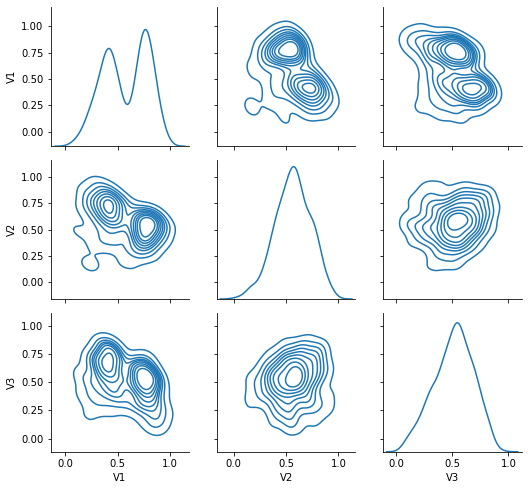

In [15]:
g = sns.PairGrid(pd.DataFrame(x_train_scaled,columns=x_train.columns).iloc[:,:3].sample(600, random_state=RANDOM_SEED))
plt.subplots_adjust(top=0.9)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot);

### Construção do Autoencoder

In [16]:
X_SHAPE = x_train.shape[1]

In [17]:
model = models.Sequential()

## encoder
model.add(layers.Dense(16,input_dim=X_SHAPE,activation='elu'))
model.add(layers.Dense(8,activation='elu'))
model.add(layers.Dense(4,activation='elu'))

## vetor latente
model.add(layers.Dense(2,activation='elu',name='VETOR_LATENTE'))

## decoder
model.add(layers.Dense(4,activation='elu'))
model.add(layers.Dense(8,activation='elu'))
model.add(layers.Dense(16,activation='elu'))

## output_layer
model.add(layers.Dense(X_SHAPE,activation='elu'))

model.compile(optimizer='adam', loss='mse')
model.summary();

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                464       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
VETOR_LATENTE (Dense)        (None, 2)                 10        
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_5 (Dense)              (None, 16)                1

In [18]:
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=int(EPOCHS*0.1),
    verbose=1, 
    mode='min',
    restore_best_weights=True
)

### Treinamento do Autoencoder

In [19]:
fitting_data = model.fit(x_train_scaled,
                         x_train_scaled,
                         epochs=EPOCHS,
                         batch_size=BATCH_SIZE,
                         callbacks=early_stop,
                         validation_data=(x_val_scaled,x_val_scaled),
                         verbose=1)

Epoch 1/100
313/313 [==============================] - 2s 3ms/step - loss: 0.0490 - val_loss: 0.0177
Epoch 2/100
313/313 [==============================] - 1s 2ms/step - loss: 0.0176 - val_loss: 0.0175
Epoch 3/100
313/313 [==============================] - 1s 2ms/step - loss: 0.0170 - val_loss: 0.0165
Epoch 4/100
313/313 [==============================] - 1s 2ms/step - loss: 0.0160 - val_loss: 0.0156
Epoch 5/100
313/313 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0152
Epoch 6/100
313/313 [==============================] - 1s 2ms/step - loss: 0.0151 - val_loss: 0.0150
Epoch 7/100
313/313 [==============================] - 1s 2ms/step - loss: 0.0149 - val_loss: 0.0148
Epoch 8/100
313/313 [==============================] - 1s 2ms/step - loss: 0.0148 - val_loss: 0.0147
Epoch 9/100
313/313 [==============================] - 1s 2ms/step - loss: 0.0147 - val_loss: 0.0146
Epoch 10/100
313/313 [==============================] - 1s 2ms/step - loss: 0.0146 - val_lo

### Encontrando Anomalias

In [20]:
## transformando dados de teste (holdout)
x_test_scaled = pipe.transform(x_test)

## reconstruindo dados
reconstrucao  = model.predict(x_test_scaled)

In [21]:
## calculando a loss (mse -> anomaly score)

anon_score = np.mean(np.power(x_test_scaled - reconstrucao,2),axis=1)

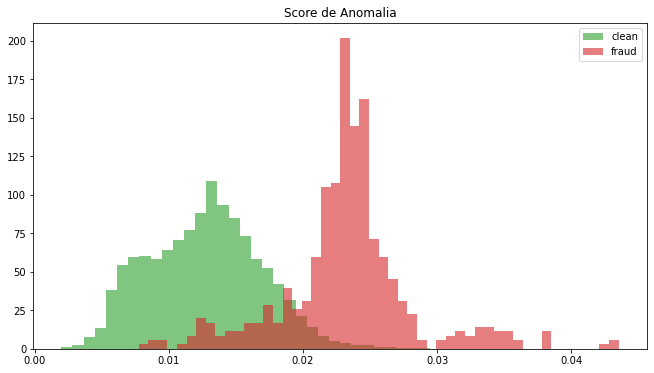

In [23]:
clean = anon_score[y_test == 0]
fraud = anon_score[y_test == 1]

fig, ax = plt.subplots(figsize=(11,6))

ax.hist(clean, bins=50, density=True, label="clean", alpha=.6, color="tab:green")
ax.hist(fraud, bins=50, density=True, label="fraud", alpha=.6, color="tab:red")

plt.title("Score de Anomalia")
plt.legend()
plt.show()

Text(60.0, 0.5, 'Real')

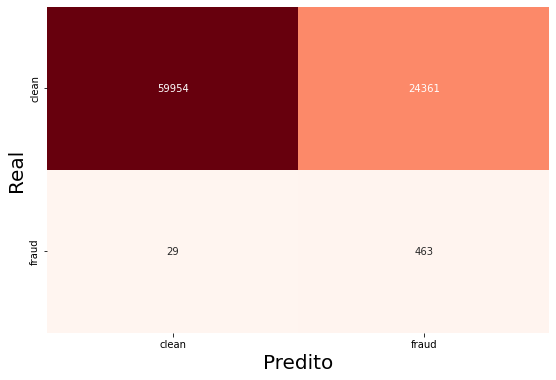

In [24]:
conf_arr = confusion_matrix(y_test,pd.Series(anon_score > 0.015).map({True:1,False:0}).values)

f ,ax = plt.subplots(1,1,figsize=(9,6))

g = sns.heatmap(conf_arr,cmap='Reds',annot=True,fmt='.0f',cbar=False, ax=ax)
g.set_xticklabels(['clean','fraud'])
g.set_yticklabels(['clean','fraud'])

g.set_xlabel('Predito',fontdict={'size':20})
g.set_ylabel('Real',fontdict={'size':20})

In [25]:
limiares = np.linspace(0.005,0.030,240)

ls_clean = []
ls_fraud = []

for limiar in limiares:
    conf_arr = confusion_matrix(y_test,pd.Series(anon_score > limiar).map({True:1,False:0}).values)
    erro_clean = conf_arr[0,1] / (conf_arr[0,:].sum())
    erro_fraud = conf_arr[1,0] / (conf_arr[1,:].sum())
    
    ls_clean.append(round(erro_clean,3))
    ls_fraud.append(round(erro_fraud,3))

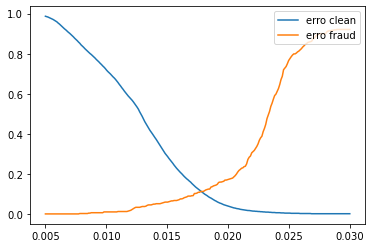

In [26]:
f, ax1 = plt.subplots()

ax1.plot(limiares,ls_clean,label = 'erro clean')
ax1.plot(limiares,ls_fraud,label = 'erro fraud')
ax1.legend(loc=1)

plt.show()

In [350]:
# ## fazendo o gif

# for i in tqdm(range(240)):
    
#     f, ax = plt.subplots()
    
#     ax.set_xlim(ax1.get_xlim())
#     ax.set_ylim(ax1.get_ylim())
    
#     ax.set_xbound(ax1.get_xbound())
#     ax.set_ybound(ax1.get_ybound())
    
#     ax.set_title(f'limiar : {limiares[i]}')
    
#     ax.plot(limiares[:i],ls_clean[:i],color='tab:blue', label = 'erro clean')
#     ax.plot(limiares[:i],ls_fraud[:i],color='tab:orange',label = 'erro fraud')
    
#     ax.legend(loc=1)
    
#     f.savefig(f'gif/frame{i}.png',dpi=600)
    
#     f.clear()
    
# plt.show()

100%|█████████████████████████████████████████| 240/240 [01:48<00:00,  2.21it/s]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

### Recriando o encoder e o decoder

In [238]:
def plot_model_values(model,x):
    
    outputs = []

    for layer in model.layers:
        keras_function = K.function([model.input], [layer.output])
        outputs.append(keras_function(x.reshape(1,-1)))
        
        
    f, ax = plt.subplots(9,1,figsize=(12,8),constrained_layout=True)

    layers_nodes = [16,8,4,2,4,8,16,28]

    ax[0].imshow(x.reshape(1,28),cmap='Reds')
    ax[0].axis('off')

    for i,value in enumerate(x):
        ax[0].text(x=i,y=0,s=round(value,2),ha="center", va="center", fontdict={'size':9})

    for i,layer in enumerate(layers_nodes):
        ax[i+1].imshow(outputs[i][0].squeeze().reshape(1,layer),cmap='Reds')
        ax[i+1].axis('off')

        for idx,value in enumerate(outputs[i][0].squeeze()):
            ax[i+1].text(x=idx,y=0,s=round(value,2),ha="center", va="center", fontdict={'size':9})

    ax[4].text(x=-3,y=0,s='VETOR LATENTE ----->')

    plt.show()

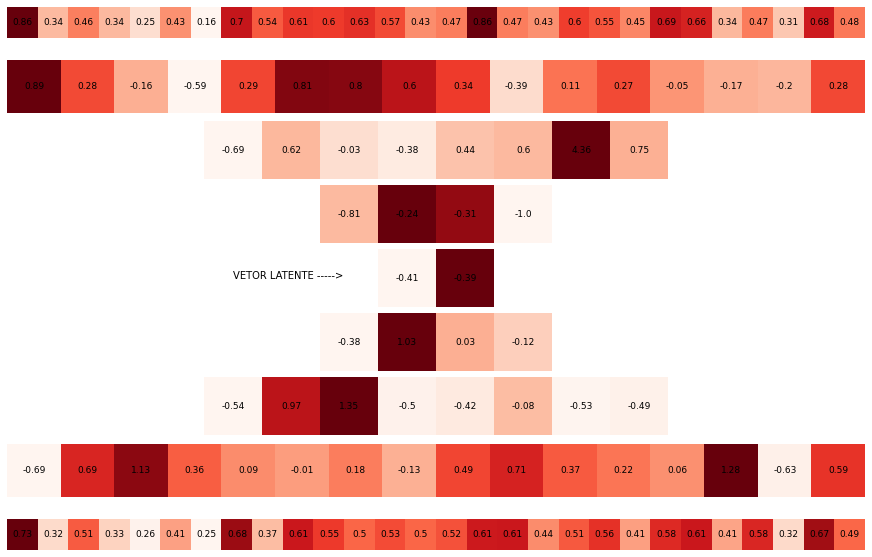

In [239]:
plot_model_values(model,x_test_scaled[0])

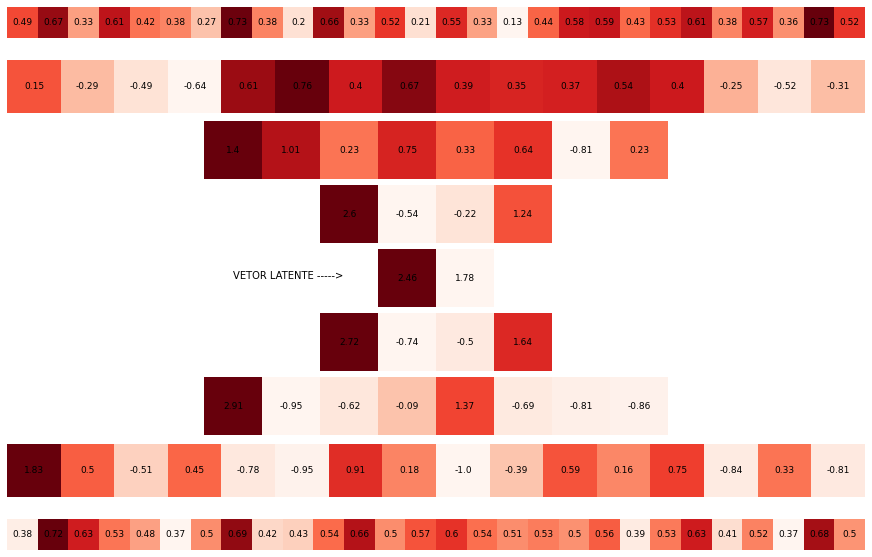

In [240]:
plot_model_values(model,x_test_scaled[y_test == 1][0])

## Não Supervisionado - Outlier Dectection

### Preparando os dados

In [293]:
train_data = (
    df
    .sample(frac=1)
)

target = train_data.Class

train_data.drop('Class',axis=1,inplace=True)
train_data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
43428,-16.526507,8.584972,-18.649853,9.505594,-13.793819,-2.832404,-16.701694,7.517344,-8.507059,-14.110184,...,3.101735,-1.514923,1.190739,-1.127670,-2.358579,0.673461,-1.413700,-0.462762,-2.018575,-1.042804
49906,0.339812,-2.743745,-0.134070,-1.385729,-1.451413,1.015887,-0.524379,0.224060,0.899746,-0.565012,...,0.432546,0.506044,-0.213436,-0.942525,-0.526819,-1.156992,0.311211,-0.746647,0.040996,0.102038
29474,1.399590,-0.590701,0.168619,-1.029950,-0.539806,0.040444,-0.712567,0.002299,-0.971747,0.756801,...,1.192245,0.212877,0.102398,0.168269,-0.166639,-0.810250,0.505083,-0.232340,0.011409,0.004634
276481,-0.432071,1.647895,-1.669361,-0.349504,0.785785,-0.630647,0.276990,0.586025,-0.484715,-1.376648,...,0.101264,-0.244633,0.358932,0.873663,-0.178642,-0.017171,-0.207392,-0.157756,-0.237386,0.001934
278846,2.014160,-0.137394,-1.015839,0.327269,-0.182179,-0.956571,0.043241,-0.160746,0.363241,0.259452,...,0.404711,-0.255293,-0.238644,-0.616400,0.347045,0.061561,-0.360196,0.174730,-0.078043,-0.070571


In [294]:
x_train, x_test, y_train, y_test = train_test_split(train_data,target,test_size=VAL_SIZE,random_state=RANDOM_SEED)

In [299]:
pipe = make_pipeline(Normalizer(),MinMaxScaler())
pipe

Pipeline(steps=[('normalizer', Normalizer()), ('minmaxscaler', MinMaxScaler())])

In [300]:
x_train_scaled = pipe.fit_transform(x_train)
x_test_scaled = pipe.transform(x_test)

### Construção do Autoencoder

In [301]:
X_SHAPE = x_train_scaled.shape[1]

In [302]:
model = models.Sequential()

## encoder
model.add(layers.Dense(16,input_dim=X_SHAPE,activation='elu'))
model.add(layers.Dense(8,activation='elu'))
model.add(layers.Dense(4,activation='elu'))

## vetor latente
model.add(layers.Dense(2,activation='elu',name='VETOR_LATENTE'))

## decoder
model.add(layers.Dense(4,activation='elu'))
model.add(layers.Dense(8,activation='elu'))
model.add(layers.Dense(16,activation='elu'))

## output_layer
model.add(layers.Dense(X_SHAPE,activation='elu'))

model.compile(optimizer='adam', loss='mse')
model.summary();

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 16)                464       
_________________________________________________________________
dense_15 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_16 (Dense)             (None, 4)                 36        
_________________________________________________________________
VETOR_LATENTE (Dense)        (None, 2)                 10        
_________________________________________________________________
dense_17 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 40        
_________________________________________________________________
dense_19 (Dense)             (None, 16)               

In [341]:
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=int(EPOCHS*0.1),
    verbose=1, 
    mode='min',
    restore_best_weights=True
)

### Treinamento do Autoencoder

In [343]:
fitting_data = model.fit(x_train_scaled,
                         x_train_scaled,
                         epochs=EPOCHS,
                         batch_size=BATCH_SIZE,
                         callbacks=early_stop,
                         validation_data=(x_test_scaled,x_test_scaled),
                         verbose=0)

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping


### Encontrando anomalias

In [344]:
## reconstruindo dados
reconstrucao  = model.predict(x_test_scaled)

In [345]:
## calculando a loss (mse -> anomaly score)

anon_score = np.mean(np.power(x_test_scaled - reconstrucao,2),axis=1)

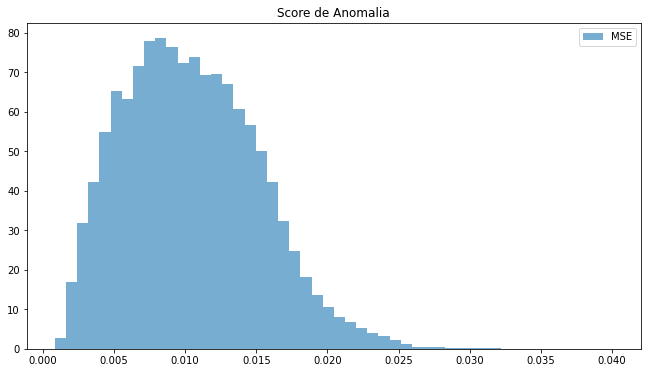

In [346]:
fig, ax = plt.subplots(figsize=(11,6))

ax.hist(anon_score, bins=50, density=True, label='MSE', alpha=.6, color="tab:blue")
# ax.axvline(np.median(anon_score),alpha=.6,ls='--',color='tab:red',label='Mediana')
# ax.axvspan(np.percentile(anon_score,95), anon_score.max(), alpha=0.2, color='tab:red')

plt.title("Score de Anomalia")
plt.legend()
plt.show()

In [347]:
(anon_score[y_test == 1] > np.percentile(anon_score,95)).sum() / len(anon_score[y_test == 1])

0.8888888888888888